In [1]:
import torch
from torchvision import models
import numpy as np

from matplotlib import pyplot as plt
import cv2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model = models.resnet50(pretrained=True).to(device)

/home/milte/anaconda3/envs/torch-cv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/milte/anaconda3/envs/torch-cv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
model = torch.nn.Sequential(*list(model.children())[:-2])

In [5]:
def load_img(path,imshape=(1024,1024)) -> np.ndarray:
    img = cv2.imread(path)
    return cv2.resize(img,imshape)
    

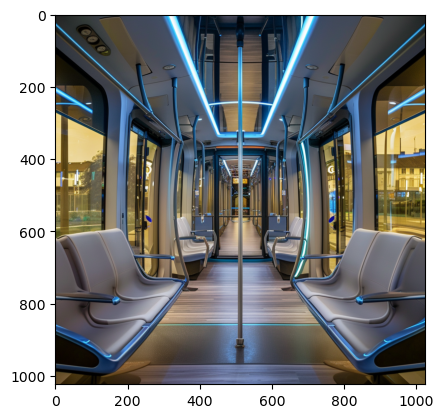

In [6]:
im1 = load_img("/home/milte/Desktop/ainspired/data/ai/1B_17_4.png")

plt.imshow(im1)
plt.show()

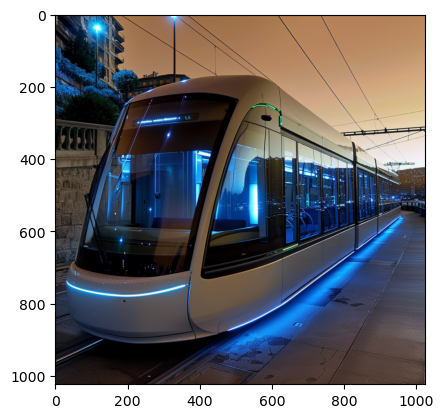

In [7]:
im2 = load_img("/home/milte/Desktop/ainspired/data/ai/1B_15_4.png")
plt.imshow(im2)
plt.show()

In [8]:
im2.shape

(1024, 1024, 3)

In [9]:
def img_to_tensor(img):
    return torch.Tensor(img).unsqueeze(0).view((1,3,*img.shape[:2])).to(device)

In [10]:
import torch.nn.functional as F

def cosine_similarity(feature1, feature2):
    # Normalize feature vectors
    feature1 = F.normalize(feature1, dim=0)
    feature2 = F.normalize(feature2, dim=0)
    
    # Compute cosine similarity
    similarity = torch.sum(feature1 * feature2, dim=0)
    return similarity.to(device)

In [11]:
im1_tensor = img_to_tensor(im1)
im2_tensor = img_to_tensor(im2)

In [12]:
out1 = model(im1_tensor)
out2 = model(im2_tensor)

In [13]:
image_similarity = cosine_similarity(out1.flatten(),out2.flatten())
image_similarity

tensor(0.3236, device='cuda:0', grad_fn=<SumBackward1>)

In [14]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import RawScoresOutputTarget

In [15]:
class SimilarityTarget(RawScoresOutputTarget):
    def __init__(self,features_2) -> None:
        super().__init__()
        self.f2 = features_2
    def __call__(self, model_output):
        print(model_output.shape)
        return cosine_similarity(model_output.flatten(),self.f2.flatten())

In [16]:
target_layer = model[-1]  # Last conv layer in ResNet
cam = GradCAM(model=model, target_layers=[target_layer])

In [17]:
# For Image 1
grayscale_cam1 = cam(input_tensor=im1_tensor, targets=[SimilarityTarget(out2)])

torch.Size([2048, 32, 32])


In [18]:
grayscale_cam2 = cam(input_tensor=im2_tensor, targets=[SimilarityTarget(out1)])

torch.Size([2048, 32, 32])


In [19]:
cam_image1 = show_cam_on_image(im1/255, grayscale_cam1[0], use_rgb=True)
cam_image2 = show_cam_on_image(im2/255, grayscale_cam2[0], use_rgb=True)

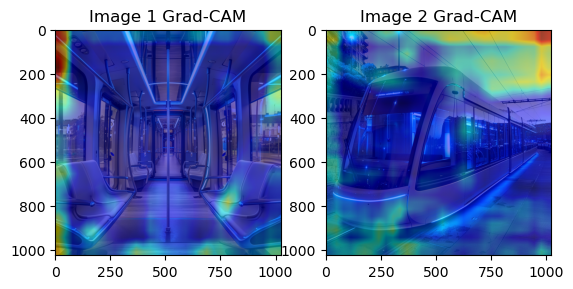

In [20]:
plt.subplot(1, 2, 1)
plt.imshow(cam_image1)
plt.title("Image 1 Grad-CAM")

plt.subplot(1, 2, 2)
plt.imshow(cam_image2)
plt.title("Image 2 Grad-CAM")
plt.show()

this is dumb and I should have known it wouldn't work

In [21]:
torch.cuda.empty_cache()